# Kinetic energy and battery efficiency determination from real vehicle data

An important part of our algorithm for the routing optimization is the calculation of the energy that an electric vehicle (EV) requires in order to travel a given arc of the route graph. In the current algorithm version, this energy calculation is based on the assumption that the EV travels along the arc with a constant mean velocity given by the OpenRouteService API. Details on how this energy is calculated can be found [here](https://eclever.atlassian.net/wiki/spaces/ROUTE/pages/1193639941/Optimum+Route+Velocity+Charge+Stops+and+Overall+Route+Time+Estimation).

However, this calculation neglects the energy that is consumed/gained when there is a change in kinetic energy, i.e., when there is an acceleration/deceleration event. This part of the total energy consumption is not easy to determine a priory since it depends on many unforeseeable factors like traffic conditions (e.g., traffic jams, traffic lights), road type and conditions (e.g., road quality, constructions, turnarounds, curves), among others. Also quite important is that the kinetic energy term entails the human factor, since the driving style (aggressive/conservative) of the driver highly affects the overall energy consumption.

In this report we aim to find a way to determine the amount of Kinetic energy that is consumed when a EV travels a given route. This we do by comparing the calculated energy consumption profile of the route and the real energy consumption for that route from empirical driving data. 

After performing an optimization on the energy consumption with respect to real driving data, we can estimate the amount of kinetic energy consumed on the route together with the EV motors efficiency. After a statistical analysis of possible correlations, we observe that the amount of kinetic energy consumed depends on the driving conditions, more specifically on whether one drives in the city or on a highway. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Current-Model" data-toc-modified-id="Current-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Current Model</a></span></li><li><span><a href="#Proposed-Model" data-toc-modified-id="Proposed-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Proposed Model</a></span><ul class="toc-item"><li><span><a href="#Correlations" data-toc-modified-id="Correlations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Correlations</a></span><ul class="toc-item"><li><span><a href="#$eff$---Speed,-$eff$---Total-Distance-and-$f_{\rm-kin}$---Total-Distance" data-toc-modified-id="$eff$---Speed,-$eff$---Total-Distance-and-$f_{\rm-kin}$---Total-Distance-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>$eff$ - Speed, $eff$ - Total Distance and $f_{\rm kin}$ - Total Distance</a></span></li><li><span><a href="#$f_{\rm-kin}$---Speed" data-toc-modified-id="$f_{\rm-kin}$---Speed-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>$f_{\rm kin}$ - Speed</a></span></li><li><span><a href="#$f_{\rm-kin}$---$eff$" data-toc-modified-id="$f_{\rm-kin}$---$eff$-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>$f_{\rm kin}$ - $eff$</a></span></li></ul></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Discussion</a></span><ul class="toc-item"><li><span><a href="#Comparison-with-other-cars/drivers" data-toc-modified-id="Comparison-with-other-cars/drivers-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Comparison with other cars/drivers</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, warnings
sys.path.append('../chargecurve/')
warnings.filterwarnings('ignore')
from databases import load_base2_ftp, query_station
from functions import get_peaks, collect_drives
from chargecurve import AutoDrive, DriveCurve
import datetime
import openrouteservice as ors
from openrouteservice import client
import folium
from energyCalculations import getProfileEnergy, getGeoDistance, E_fric, E_grav, E_aero, P_heating
from routing import query_vehicle 

In [56]:
# Define functions needed to do the analysis
def getAltitude(drive):
    """
    Function to enrich location information (altitude, longitude) with altitude data, required to calculate 
    energy consumption of the route
    """
    actualroute = list(zip(drive.longitude.values, drive.latitude.values))
    
    elUrl="http://10.48.0.50:5000"
    elClnt = client.Client(base_url=elUrl) 
    elevation = ors.elevation.elevation_line(elClnt, format_in='polyline', geometry=actualroute, 
                                             format_out='polyline')
    elevation = elevation['geometry']
    
    long = [item[0] for item in elevation]
    lat = [item[1] for item in elevation]
    alt = [item[2] for item in elevation]
    elevation_df = pd.DataFrame({'long': long,'lat': lat, 'altitude':alt})
    
    return elevation_df

def plotRouteEProfile(profile, drive, text=''):
    """
    Plots the calculated and real energy consumption profile of the route in terms of SoC, together with
    the route altitude.
    """
    
    fig, (ax1, ax3) = plt.subplots(1,2,figsize = (20,7))
    ax1.plot(profile.x,profile.SoC*100, label='calculated', color='green')
    ax1.plot(profile.x,drive.hvSocActualDisplay.iloc[:-1], label='real', color='orange')
    ax1.grid(True)
    ax1.set_ylabel('SoC [%]', fontsize='x-large')
    ax1.set_xlabel('Distance [km]', fontsize='x-large')
    ax1.legend(loc='lower left',fontsize='x-large')
    ax1.set_title('Speed Mean: {:.1f}, Median {:.1f}'.format(drive.speed_ave, drive.speed.median()))
    
    ax2 = ax1.twinx()
    ax2.fill_between(profile.x,profile.altitude, alpha = 0.2, label = 'Altitude')
    ax2.set_ylim(profile.altitude.min()-20, profile.altitude.max()+20)
    ax2.set_ylabel('Altitude [m]', fontsize='x-large')
    ax2.legend(fontsize='x-large')
    
    ax3.plot(profile.x, drive.speed.iloc[:-1])
    ax3.axhline(y=drive.speed_ave, label='mean', color='red', linestyle='-')
    ax3.axhline(y=drive.speed.median(), label='median', color='red', linestyle='--')
    ax3.legend(fontsize='x-large')
    ax3.set_xlabel('Distance [km]', fontsize='x-large')
    ax3.set_ylabel('Speed [km/h]', fontsize='x-large')
    fig.text(0.5,0,text, fontsize='x-large')
    plt.tight_layout
    
def getEnergy(auto, speed, profile, T_in=20, T_out=20, T_target=20, 
                     soc_ini = 1, wind=False, wet=False):
    """
    Calculates the energy consumption profile of a Route.
    
    Parameters:
    ----------
    auto: Pandas DataFrame with vehicle information (From query_vehicle function)
    speed (float): Vehicle velocity in km/h.
    profile: Pandas DataFrame with Route Profile.
    T_in,, T_out (float): Temperatures inside, outside the vehicle in °C.
    T_target (float): Air conditipon/heatig: target temperature in °C.
    wind (float): wind velocity in km/h
    soc_ini (float): Initial State of Charge of the Battery in % (1 is 100%.)
    wet (bool): true if it rains false otherwise.
    
    Returns:
    --------
    Returns the profile DataFrame complemented with the Energy consumption profile.
    
    """
    
    # auto params
    eff = 0.8
    batt = auto.nettoKwh[0]
    mass = auto.emptyWeight[0]
    area = auto.area[0]
    c_drag=auto.dragFactor[0]
    
    # route params
    profile['altitude1'] = profile['altitude'].shift(-1)
    profile['x'] = getGeoDistance(profile)[1]
    profile['dx'] = getGeoDistance(profile)[0]

    profile=profile.dropna()
    
    #calculate energies    
    profile['E_fric'] = [E_fric(mass, profile['dx'].iloc[i]*1000, profile['altitude'].iloc[i],
                                profile['altitude1'].iloc[i], wet) 
                         for i in range(len(profile))]
    
    profile['E_grav'] = [E_grav(profile['altitude'].iloc[i],profile['altitude1'].iloc[i], mass)
                         for i in range(len(profile))]

    profile['E_aero'] = [(E_aero(speed, T_out, area, c_drag, profile['altitude'].iloc[i], 
                                 profile['dx'].iloc[i]*1000, wind=0) 
                          + E_aero(speed, T_out, area, c_drag, profile['altitude1'].iloc[i], 
                                   profile['dx'].iloc[i]*1000, wind=0))/2 
                         for i in range(len(profile))]

    profile['E_heating'] = [P_heating(T_in, T_out, T_target)*(profile['dx'].iloc[i])/(speed) 
                            for i in range(len(profile))]
    
    profile['E_elec'] = [0.5*(profile['dx'].iloc[i])/(speed) for i in range(len(profile))]
    
    profile['E_tot'] = (profile['E_fric'] 
                        + profile['E_grav']
                        + profile['E_aero']
                        + profile['E_elec'] 
                        + profile['E_heating'])
    
    return profile[['x','E_tot']]

import matplotlib.gridspec as gridspec
from scipy.optimize import minimize

def minimizeProfile(drive, auto, statistic='median', text='', plot=False):
    """
    Minimizes the difference of the calculated and real energy consumption profiles of a route
    a determines the amount of kinetic energy in terms of the constant speed energy, together with
    the motor efficiency. If Plot is set to True, a plot is generated showing the corrected (minimized)
    consumption and the difference.
    """
    
    batt = auto.nettoKwh[0]
    eff = 0.8
    soc_ini=drive.hvSocActualDisplay.iloc[0]/100
    profile = getAltitude(drive)
    
    if statistic == 'median':
        speed =  drive.speed.median()
    
    elif statistic == 'mean':
        speed =  drive.speed.mean()
    
    else:
        print('Possible statistics values are median and mean')
    
    calcProfile = getEnergy(auto, speed, profile, soc_ini=soc_ini)

    realProfile = drive.hvSocActualDisplay

    fun = lambda x: np.nansum(
        np.sqrt((realProfile.values[:-1]
                 - (batt*soc_ini - np.nancumsum(calcProfile['E_tot'].values*(1+x[0])/x[1]))*100/batt)**2))

    res = minimize(fun, (1.2, 0.8), method='SLSQP', bounds=((0,5),(0,1)))
   
    SoC_cal =  (batt*soc_ini - np.nancumsum(calcProfile['E_tot'].values/eff))*100/batt
    SoC_cor =  (batt*soc_ini - np.nancumsum(calcProfile['E_tot'].values*(1+res.x[0])/res.x[1]))*100/batt
    diff = (realProfile.values[:-1] - SoC_cor)
    
    result = {'distance':calcProfile.x.values.round(2),
              'SoC corrected':SoC_cor.round(2),
              'SoC real': realProfile.iloc[:-1].values,
              'speed': speed.round(2),
              'distance total':calcProfile.x.values.round(2).max(),
              'eff':res.x[1].round(2),
              'f_kin':res.x[0].round(2),
             }
    if drive.speed.median() < 60:
        result['highway'] = 0
    else:
        result['highway'] = 1
    
    if plot:
        
        fig = plt.figure(figsize=(10,7))
        gs = gridspec.GridSpec(3, 2)

        ax = fig.add_subplot(gs[0:2, :])
        ax.plot(calcProfile.x,SoC_cal, label='calculated (eff=0.8)', color='black', alpha=0.5)
        ax.plot(calcProfile.x,SoC_cor, label=r'corrected (eff={}, $f_{{\rm kin}}$ = {})'.format(res.x[1].round(2),
                                                                                             res.x[0].round(2)), color='green')
        ax.plot(calcProfile.x,realProfile.iloc[:-1], label='real', color='orange')
        ax.set_xlabel('Distance [km]', fontsize='x-large')
        ax.set_ylabel('SoC [%]', fontsize='x-large')
        plt.legend(fontsize='x-large')
        plt.grid()

        ax = fig.add_subplot(gs[2, :])
        ax.plot(calcProfile.x,diff, label='diff', color='blue')
        ax.axhline(y=0, linestyle='--', color='black')
        ax.set_xlabel('Distance [km]', fontsize='x-large')
        ax.set_ylabel(r'SoC$_{real}$- SoC$_{corr}$', fontsize='x-large')
        plt.legend(fontsize='x-large')
        fig.text(0.5,0,text, fontsize='x-large')
        fig.tight_layout
    
    return result

In [57]:
##load data
hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']
auto = query_vehicle('IONIQ Elektro')

#select drive data
mask = (hyundai.speed > 1) & (hyundai.hvBatteryCurrent != 1) 
hyundai_drives = collect_drives(hyundai[mask])
HyundaiDriveCurve = DriveCurve(hyundai_drives)

## Current Model

As already mentioned, the current model for the energy consumption determination assumes that there is no acceleration and hence, the EV travels with constant speed. This model can be expressed as follows:

$$
E_{\rm Const~Speed} = (E_{\rm aero} + E_{\rm fric} + E_{\rm grav} + E_{\rm heating} +E_{\rm electronics})/eff
$$
where

$E_{\rm aero} = $ Aerodynamic energy (wind resistance).

$E_{\rm fric} = $ Energy to overcome friction resistance.

$E_{\rm grav} = $ Potential energy due to change in altitude.

$E_{\rm heating} = $ Energy consumed by the heating/cooling.

$E_{\rm electronics} = $ Energy consumed by car electronics and auxiliary features.

$eff = $ Motor efficiency, currently set to 0.8.

In order to see how accurate this model is to determine energy consumption let us compare its prediction with real empirical consumption data.    

The figure below shows the energy consumption in terms of the State of Charge (SoC) of the battery as a function of the traveled distance for several routes driven by a Hyundai Ioniq. Figures at the left show the calculated  energy consumption (green line) and the real-world data (orange line). The blue shaded area shows the change in altitude along the route. 

By comparing the green and orange lines, it is quite obvious that the calculated curve, in most cases, underestimates the energy consumption. The plots at the right of the figures show the speed as a function of traveled distance for the given route. Red lines in the plot show the mean (full line) and median (dashed line) speed values. The green curves at the left are calculate using the median speed value.

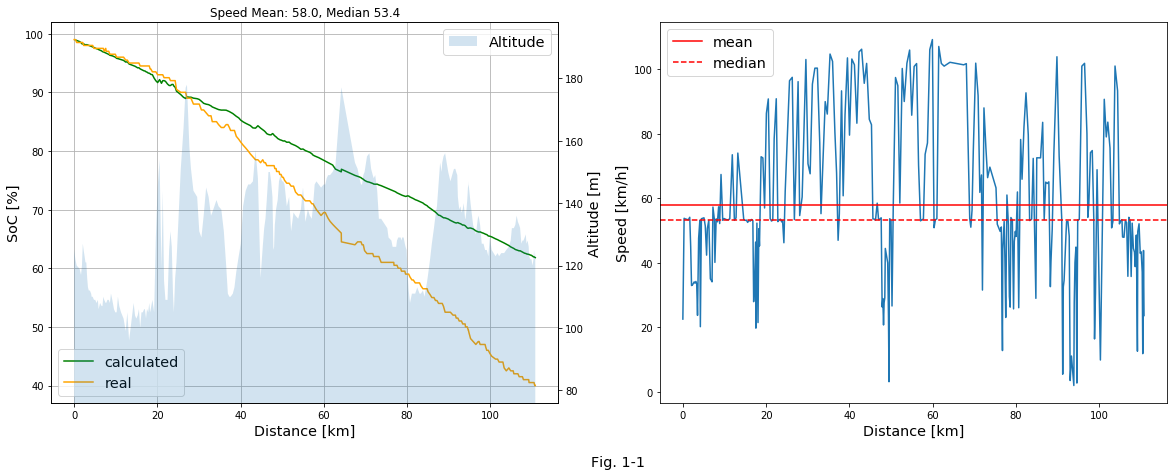

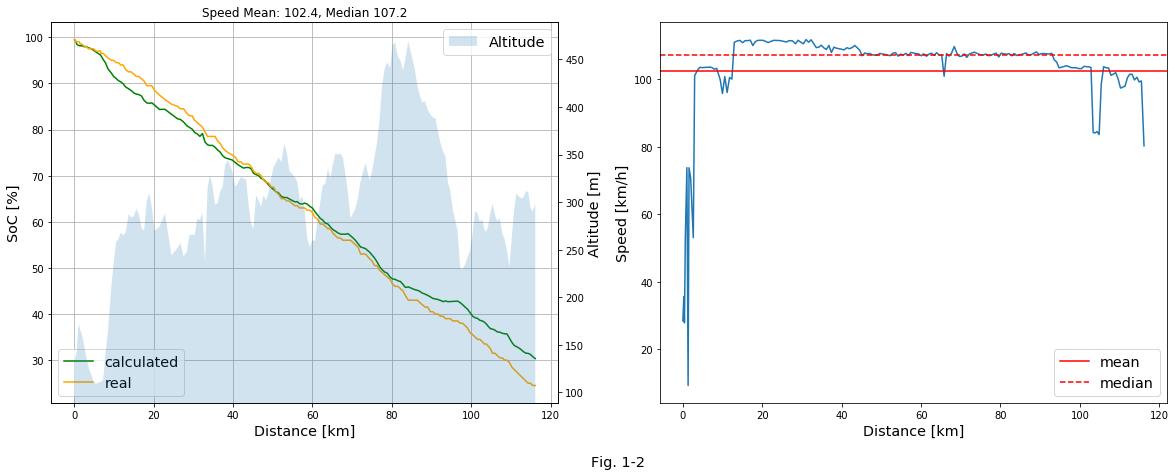

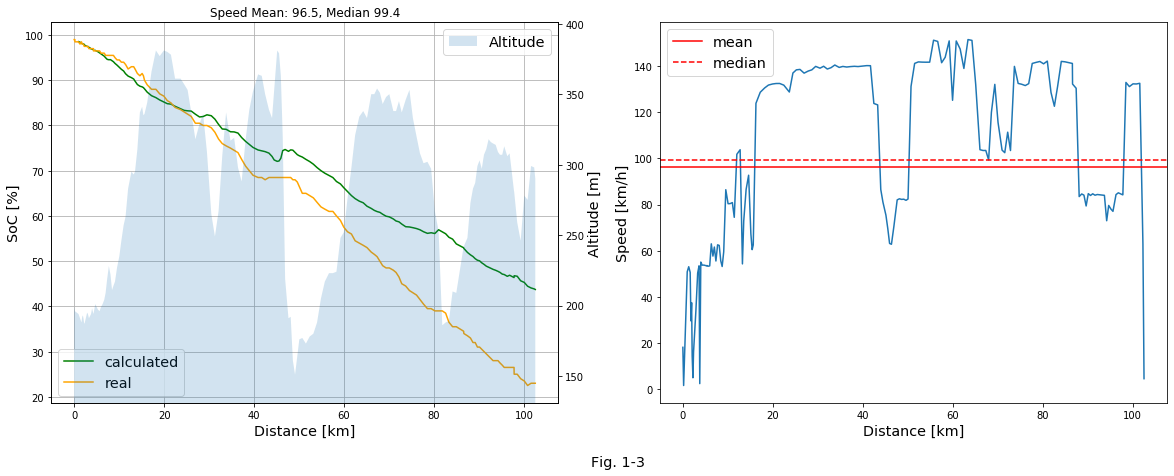

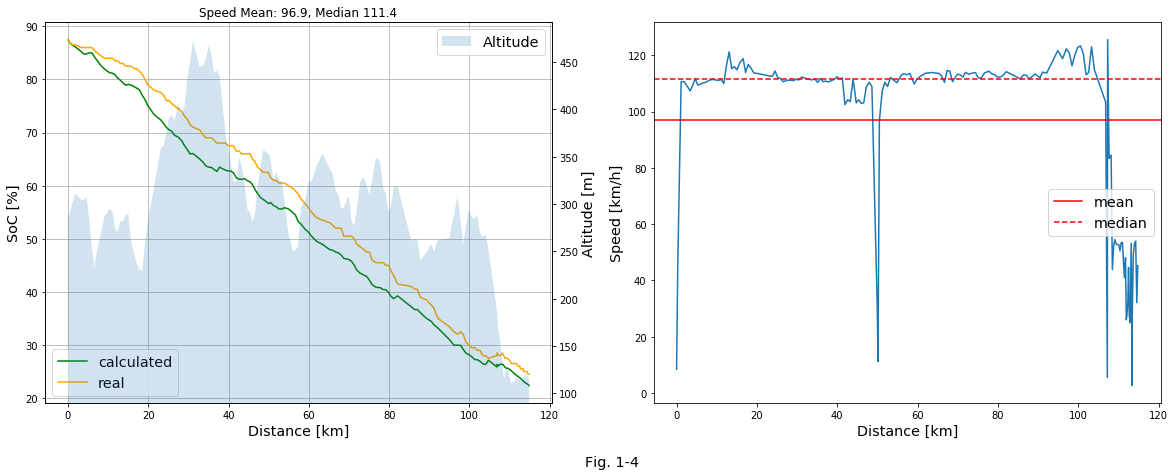

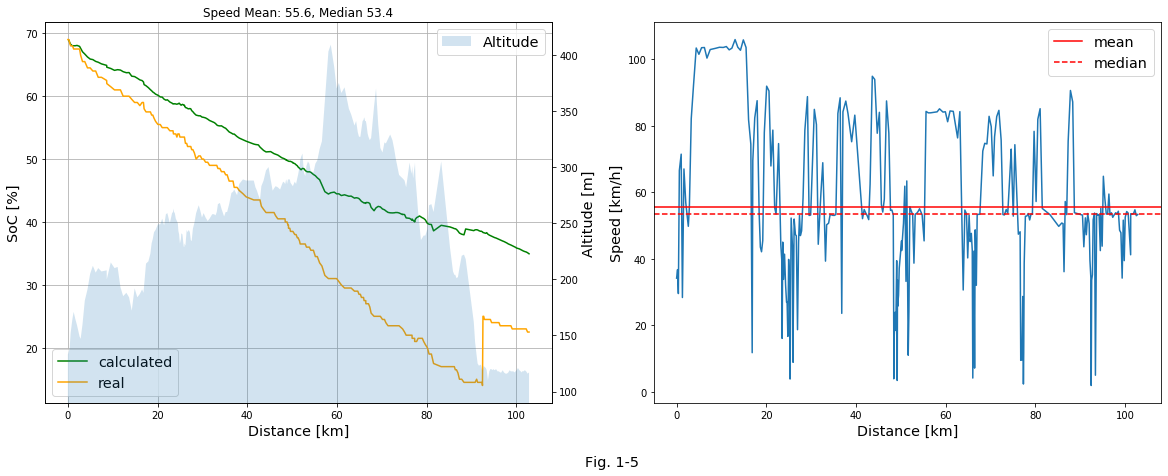

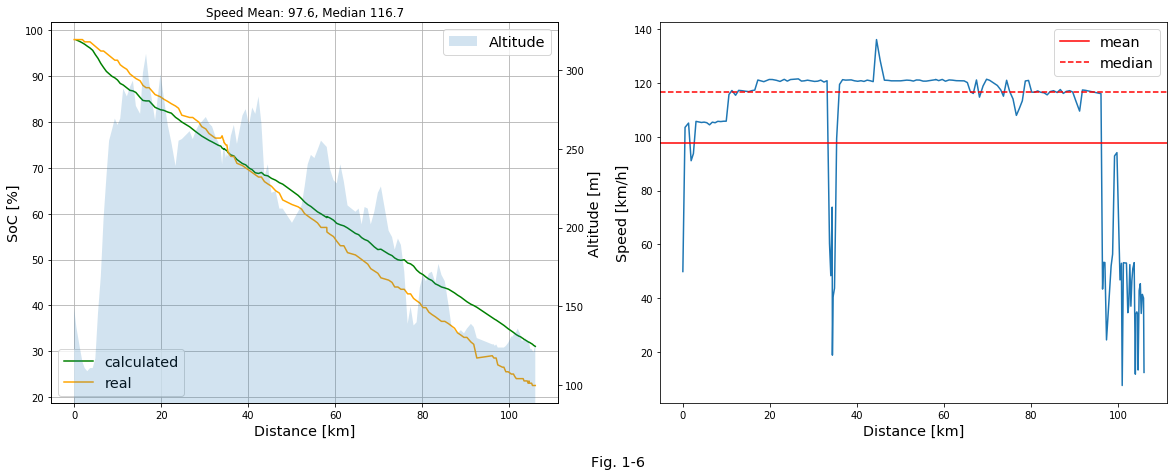

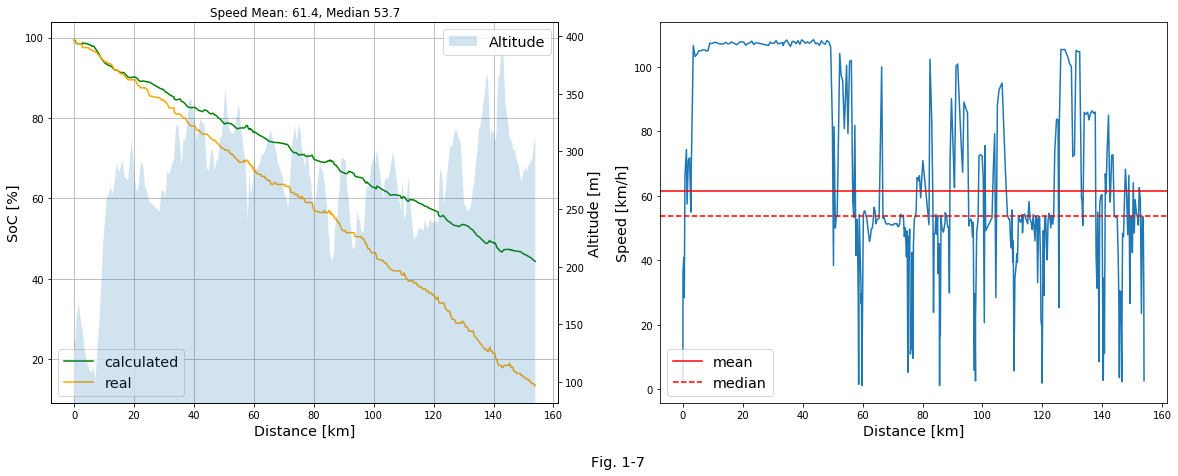

In [58]:
# Plot energy consumption profiles for some ioniq routes
i=0
for drive in hyundai_drives:
    if drive.distance > 100:
        i+=1
        soc_ini=drive.hvSocActualDisplay.iloc[0]/100
        profile = getAltitude(drive)
        
        energyProfile = getProfileEnergy(auto, drive.speed.median(), profile, 
                                         soc_ini=soc_ini, eff=0.8)

        plotRouteEProfile(energyProfile, drive, text='Fig. 1-{}'.format(i))

Rather interesting is that for those routes where there are less speed variations along the route, the calculated curves are closer to the real data. Some examples are for instance figure 1-2 and 1-4. The reason for this is that small speed variations means an almost constant speed, which is the main assumption of our current model. On the other hand, large speed variations imply acceleration and deceleration events. These events contribute to the overall energy consumption by means of change in kinetic energy, which is not considered in our current model. Figure 1-7 (right) for example, shows an almost constant speed for route distance between 5 to 50 km, after 50 km the speed varies a lot. The energy associated with this speed changes is not considered in our model and therefore, the green and orange lines in Fig. 1-7 (left) diverge.

Now the question is, how can we find out the amount of kinetic energy that is missing in our model, specially when this value is not easily predictable since, as earlier discussed, it depends on many unpredictable factors?.

## Proposed Model

In order to answer the above question we will proceed as follows. First we will assume that the only term missing in the energy equation is the change in kinetic energy. Second, we will express the kinetic energy in terms of the so far calculated energy at constant speed $E_{\rm Const. Speed}$. In this way, the total energy of the route is

$$
E_{\rm Tot} = \dfrac{\left[ E_{\rm Const. Speed} \cdot (1+f_{\rm kin}) \right]}{eff}
$$

Note that $f_{\rm kin}$ is just a number that represents the amount of energy as fraction of $E_{\rm Const. Speed}$. So for instance, if $f_{\rm kin} = 0.5$ this means that the amount of Kinetic energy is corresponds to 50% of $E_{\rm Const. Speed}$. For some cases $f_{\rm kin} = 0.5$ could be larger than 1, meaning that the amount of kinetic energy is larger than the calculated $E_{\rm Const. Speed}$.

To determine the values of $f_{\rm kin}$ and $eff$ we will use an optimization approach where we will try to find the optimum $f_{\rm kin}$ and $eff$ values that minimizes the difference between the calculated and real consumption. Hence the objective function to be minimized is:

$$
\sum_{i=1}^{x} \sqrt{(SoC_{i~\rm real} - SoC_{i~\rm corr})^2}
$$

with 

$$
SoC_{i~\rm corr} = \sum_{k=1}^i \dfrac{\left[ E_{k~\rm Const. Speed} \cdot (1+f_{\rm kin}) \right]}{eff}\cdot \dfrac{1}{B}
$$
and $B$ being the battery capacity of the EV. Note that the value of $eff$ was constrained to be within 0 and 1. Values larger than one mean that the motor efficiency is better than 100%, i.e., that the motor is converting the battery energy with 100% efficiency and even generating more energy, which is physically impossible.

Let us now see how the corrected energy consumption $SoC_{\rm corr}$ looks like after optimizing the $f_{\rm kin}$ and $eff$ values. 

Figure 2 below shows the SoC vs. Traveled distance for the same routes shown in Fig. 1. The gray line shows the original calculated consumption line using our current constant speed model. The orange line shows again the real data, and the green line the corrected energy consumption after the minimization. The plot at the bottom, shows the difference between green and blue lines. The closer the blue lines get to zero, the more accurate is our energy consumption calculation.  

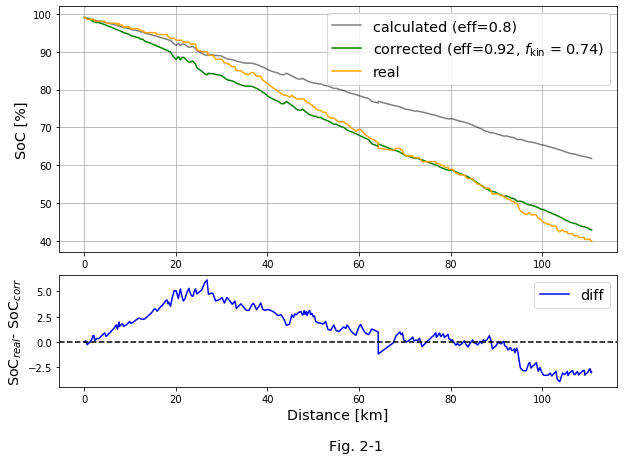

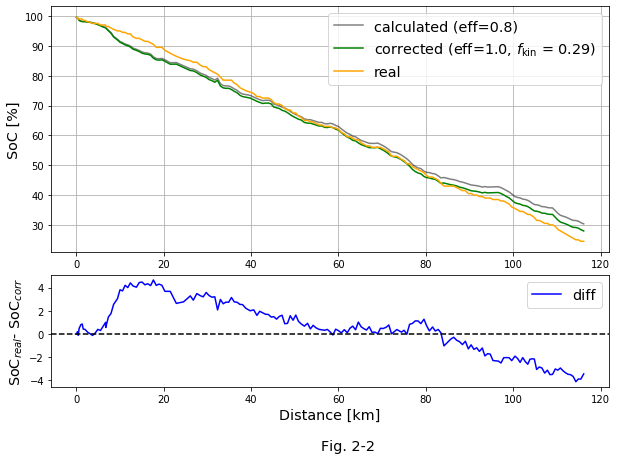

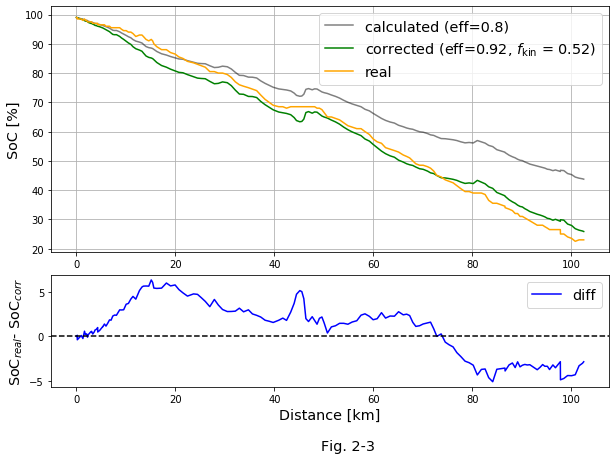

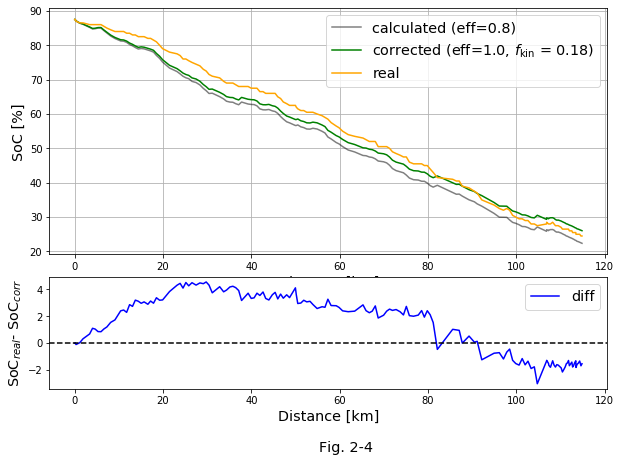

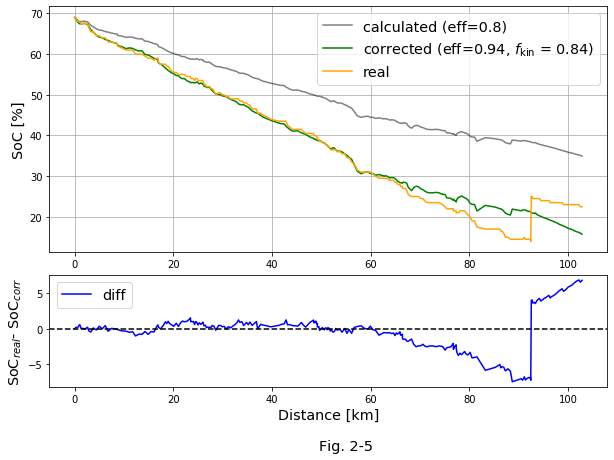

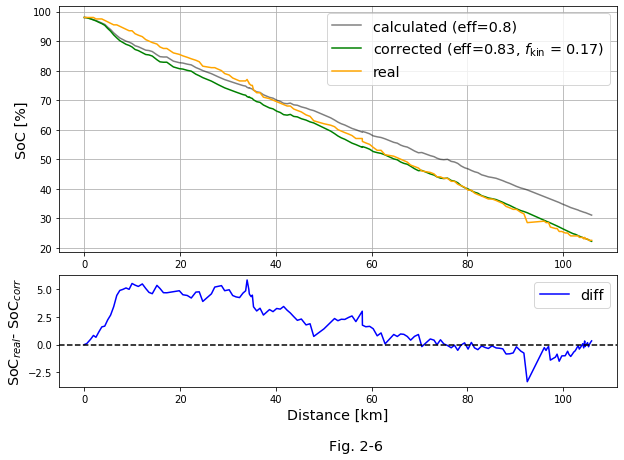

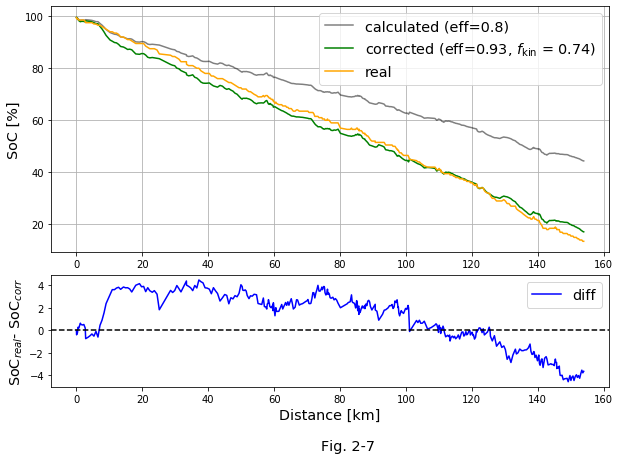

In [59]:
#Plot minimized energy consumption profiles for the Ioniq
i=0
for drive in hyundai_drives:
    if drive.distance > 100:
        i+=1
        minimizeProfile(drive, auto, statistic='median', text='Fig. 2-{}'.format(i), plot=True)

As observed in Figure 2, the optimization does a decent job to try to find out the missing Kinetic energy. Moreover, we can also determine the motor efficiency $eff$. 

In the next part we will try to determine $f_{\rm kin}$ and $eff$ for all possible routes within the available data for the Hyundai Ioniq and see if we can learn more about these terms.

### Correlations

Figures 3 and 4 show a series of plots were the optimized $f_{\rm kin}$ and $eff$ values are plotted against other important parameters such as the speed and the total trip distance. The aim here is to see if there is an evident correlation among these parameters.

The values shown in Fig. 3 and 4 correspond to optimized energy consumptions calculated using the median and mean of the speed, respectively. The blue lines show linear fits to the data and the shaded blue areas represent the confidence interval of 95%. 

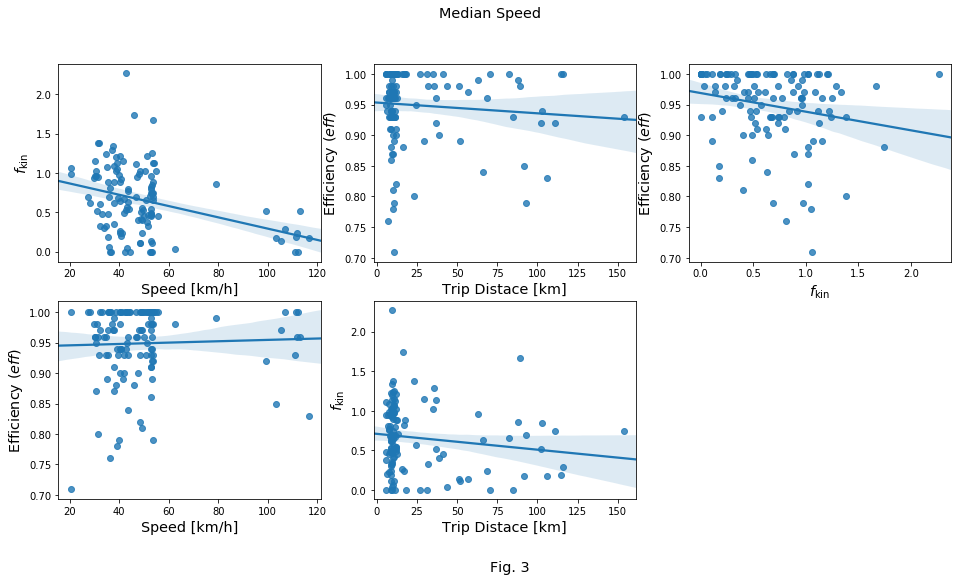

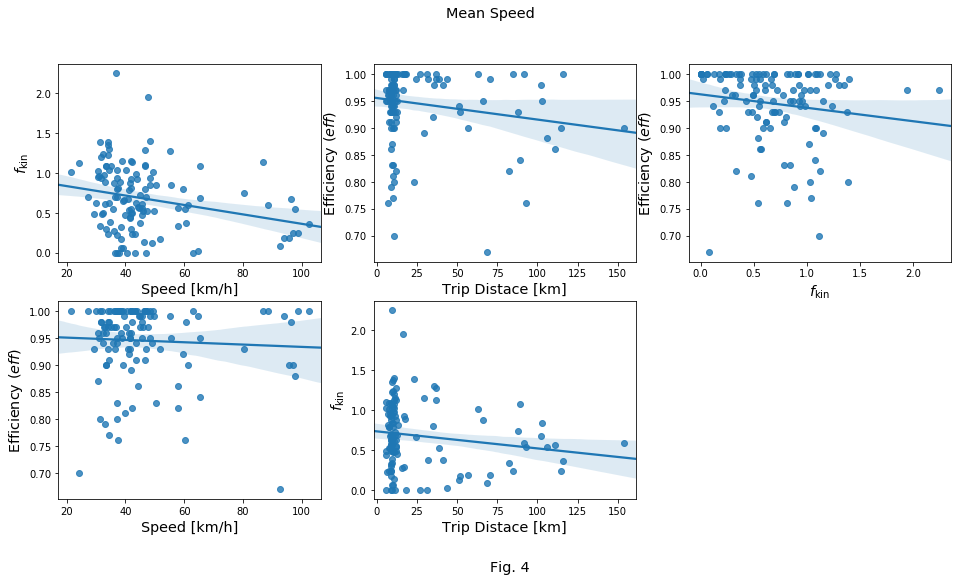

In [60]:
# minimize all available route data using Median and mean speed
data_median = [minimizeProfile(drive, auto, statistic='median') 
               for drive in hyundai_drives if drive.distance > 5]

data_mean = [minimizeProfile(drive, auto, statistic='mean') 
               for drive in hyundai_drives if drive.distance > 5]

# convert to pandas DataFrame
median_df = pd.DataFrame(data_median)
mean_df = pd.DataFrame(data_mean)

import seaborn as sn

def plotCorrelations(df, title='', text=''):
    """
    Plots features gainst each other to look for possible correlations (Linear)
    """
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(231)
    sn.regplot(df.speed, df.f_kin, ax=ax1)
    ax1.set_xlabel('Speed [km/h]', fontsize='x-large')
    ax1.set_ylabel(r'$f_{\rm kin}$', fontsize='x-large')
    
    ax2 = fig.add_subplot(232)
    sn.regplot(df['distance total'], df.eff, ax=ax2)
    ax2.set_xlabel('Trip Distace [km]', fontsize='x-large')
    ax2.set_ylabel(r'Efficiency ($eff$)', fontsize='x-large')
    
    ax3 = fig.add_subplot(233)
    sn.regplot(df.f_kin, df.eff, ax=ax3)
    ax3.set_xlabel(r'$f_{\rm kin}$', fontsize='x-large')
    ax3.set_ylabel(r'Efficiency ($eff$)', fontsize='x-large')

    ax4 = fig.add_subplot(234)
    sn.regplot(df.speed, df.eff, ax=ax4)
    ax4.set_xlabel('Speed [km/h]', fontsize='x-large')
    ax4.set_ylabel(r'Efficiency ($eff$)', fontsize='x-large')
    
    ax5 = fig.add_subplot(235)
    sn.regplot(df['distance total'], df.f_kin, ax=ax5)
    ax5.set_xlabel('Trip Distace [km]', fontsize='x-large')
    ax5.set_ylabel(r'$f_{\rm kin}$', fontsize='x-large')

    plt.suptitle(title, fontsize='x-large')
    fig.text(0.5,0,text, fontsize='x-large')
    fig.tight_layout;
    
# Linear correlation plot for median and mean speed
plotCorrelations(median_df, 'Median Speed', text='Fig. 3')
plotCorrelations(mean_df, 'Mean Speed', text='Fig. 4')

Overall, both figures show little differences, except for the point distribution when plotting against speed.  Upper and lower left plots in Fig. 3, for example, show two abrupt clustering of points, one below ~55 km/h and the other above ~100 km/h. Keep in mind that the calculations here were done using the median speed. These two clusters can be easily identified as routes which are perform within cities (lower velocities) and in highways (larger speeds). In contrast, the same plots in Fig 4, even though, they also show a clustering of points, the transition between clusters is smoother as compared to median values.

From both figures we can also observe that there seem to be a correlation between all parameters. Moreover, these correlations tend to be negative. 

Let us now statistically quantify these correlations and see if they are significant. To do so we will calculate the Pearson's $r$ coefficient.

In [61]:
from scipy.stats import pearsonr

def getPval(df, params):
    """
    Calculates the Pearson r correlation coefficient and its p value to test if 
    there is a significance in the correlation
    """
    res = pd.DataFrame()
    for i, par1 in enumerate(params):
        for j,par2 in enumerate(params):
            if par1 != par2 and i>j:
                r, p =pearsonr(df[par1],df[par2])
                res = pd.concat([res, pd.DataFrame({'Parameters':['{} - {}'.format(par1, par2)],
                                                    'r':[r.round(2)], 
                                                    'p': [p.round(2)]})], ignore_index=True)
    return res.set_index('Parameters')
    
params = ['speed', 'distance total','eff', 'f_kin']    
                            
pearson_median=getPval(median_df, params)
pearson_mean=getPval(mean_df, params)
_=pd.concat([pearson_median,pearson_mean], keys=['Median','Mean'], axis=1)
print('{:^40}'.format('Table 1'))
_.iloc[1:,:]

                Table 1                 


Median        Mean      
                            r     p     r     p
Parameters                                     
eff - speed              0.04  0.69 -0.05  0.56
eff - distance total    -0.09  0.33 -0.18  0.05
f_kin - speed           -0.34  0.00 -0.24  0.01
f_kin - distance total  -0.14  0.11 -0.16  0.08
f_kin - eff             -0.21  0.02 -0.15  0.10

Table 1 shows the value of the Pearson's $r$ coefficient together with its $p$ value. $r$  ranges from -1 to 1. A positive value means that there is a positive correlation, whereas a negative value indicates a negative correlation. The $p$ value is an estimation of the statistical significance of the value. A $p$ value larger than 0.05 means that the value has no statistical significance, in other words, there is no correlation. 

Now, lets discuss correlations between the different parameters.

#### $eff$ - Speed, $eff$ - Total Distance and $f_{\rm kin}$ - Total Distance  

As shown in Table 1, the $p$ value of $r$ for these pairs of parameters is larger or equal to 0.05 when using both mean and median speeds. This means that there is no significant correlation between these pairs of parameters.

#### $f_{\rm kin}$ - Speed

In contrast, for both median and mean speeds, the $r$ coefficient values indicate a medium negative correlation which is statistically significant. The negative correlation indicates that the larger the speed, the smaller the $f_{\rm kin}$ value. This makes perfect sense if one considers that driving larger speeds is an indication of routes being driven on a highway. In a highway, most of the time one drives at constant speed. Under normal conditions, slight changes in speed happen only when attempting to pass other drivers or by accelerating/slowing down to enter/exit the road.

Totally opposite happens when driving in a city, here acceleration/braking events take place quite often due to the traffic dynamics (traffic lights, jams, rush hours, etc). This implies that more kinetic energy is used when driving within a city than in a highway. This effect is nicely picked up by the correlation. 

To have a clearer picture on how distinct Highway/City driving conditions affect the calculated $f_{\rm kin}$ and $eff$ values, lets have a look at their histograms. In Fig. 5, the $f_{\rm kin}$ and $eff$ histograms are plotted together with a maximum likelihood gaussian distribution fit. The data has been separated in 'Highway" and "city", where Highway refers to values were the median speed value is larger than 60 km/h, lower speeds are considered city drives. As observed in the figure at the left, $f_{\rm kin}$ shows two distinct mean values depending if one drives in the city ($\sim0.70$) or in a highway ($\sim0.25$). This is basically telling us, that kinetic energy contribution of the total energy is about 70% of the constant speed term when driving in the city, and about 25% in a highway.

On the other hand, $eff$ shows no distinction of the driving conditions.

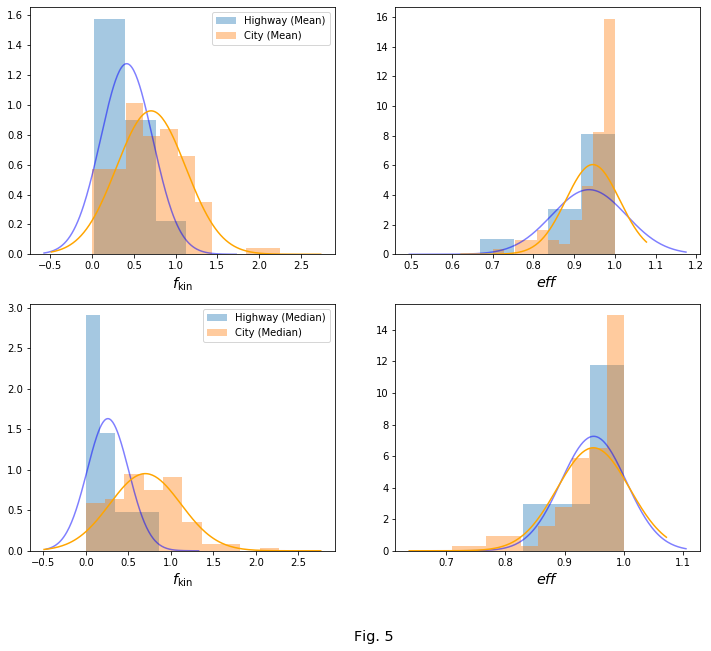

In [62]:
# plot Histograms/Distribution plot for the f_kin and Eff taking into account if driving scenarious
from scipy.stats import norm

hw_mean = mean_df[mean_df.highway==1]
city_mean = mean_df[mean_df.highway==0]
hw_median = median_df[median_df.highway==1]
city_median = median_df[median_df.highway==0]

fig = plt.figure(figsize=(12,10))
ax1=fig.add_subplot(221)
sn.distplot(hw_mean.f_kin, kde=False, fit=norm, fit_kws={"color":"blue", 'alpha':0.5}, ax=ax1, label='Highway (Mean)')
sn.distplot(city_mean.f_kin, kde=False, fit=norm, fit_kws={"color":"orange"}, ax=ax1, label='City (Mean)')
ax1.set_xlabel(r'$f_{\rm kin}$', fontsize='x-large')
ax1.legend()

ax2=fig.add_subplot(222)
sn.distplot(hw_mean.eff, kde=False, fit=norm, fit_kws={"color":"blue", 'alpha':0.5}, ax=ax2, label='Highway')
sn.distplot(city_mean.eff, kde=False, fit=norm, fit_kws={"color":"orange"}, ax=ax2, label='City')
ax2.set_xlabel(r'$eff$', fontsize='x-large')

ax3=fig.add_subplot(223)
sn.distplot(hw_median.f_kin, kde=False, fit=norm, fit_kws={"color":"blue", 'alpha':0.5}, ax=ax3, label='Highway (Median)')
sn.distplot(city_median.f_kin, kde=False, fit=norm, fit_kws={"color":"orange"}, ax=ax3, label='City (Median)')
ax3.set_xlabel(r'$f_{\rm kin}$', fontsize='x-large')
ax3.legend()

ax4=fig.add_subplot(224)
sn.distplot(hw_median.eff, kde=False, fit=norm, fit_kws={"color":"blue", 'alpha':0.5}, ax=ax4, label='Highway')
sn.distplot(city_median.eff, kde=False, fit=norm, fit_kws={"color":"orange"}, ax=ax4, label='City')
ax4.set_xlabel(r'$eff$', fontsize='x-large')

fig.text(0.5,0,'Fig. 5', fontsize='x-large')
fig.tight_layout;

In [63]:
#params = ['eff', 'E_dynamic']    
par_means = pd.DataFrame()

for m in [hw_mean, hw_median, city_mean, city_median]:
    par_means = pd.concat([par_means, pd.DataFrame({r'$f_{{\rm kin}}$':[ m.f_kin.mean().round(2)],
                                                    r'$eff$':[m.eff.mean().round(2)]
                                                   })])

par_means['Conditions']=['Highway (mean)', 'Highway (median)','City (mean)', 'City (median)']

print('{:^30}'.format('Table 2'))
par_means.set_index('Conditions', drop=True)

           Table 2            


$f_{{\rm kin}}$  $eff$
Conditions                              
Highway (mean)               0.41   0.94
Highway (median)             0.26   0.95
City (mean)                  0.71   0.95
City (median)                0.70   0.95

#### $f_{\rm kin}$ - $eff$

For this pair of parameters there is an intermediate negative correlation which is significant, but only for the values calculated using the median speed. This correlation implies that, the larger $f_{\rm kin}$, the less efficient the motor behaves. If one considers that larger $f_{\rm kin}$ are found at city drive conditions then one could, until some extend, conclude that motor efficiency is somehow lower when driving within a city than in a highway. Although, this affirmation must be backed up with more arguments that can support it.

## Discussion

As discussed in the previous section, the main two conclusions obtained are: As a first sight, the kinetic energy term of the total energy consumption depends on the driving conditions, i.e., if one drives within a city or in a highway. Hence, in city conditions, $f_{\rm kin}$ is in average about 0.70, meaning that the kinetic energy contribution to the total energy consumption has a value which is about 70% of the constant speed energy consumption. This value is reduced to 25% under highway conditions. 

Regarding the motor efficiency $eff$, its value does not seem to be affected by any other parameter, so it seems to stay constant at about 0.95. However, the motor efficiency, might change with time. The value so far calculated, was based on driving data measured in a time lapse of about three months. Keeping track of this parameter with a wider time span (e.g., several years) could show a change to lower values indicating a reduction of efficiency due to factors like aging, malfunctioning, etc. It would be also be interesting to check if $eff$ is affected by weather and seasonal conditions, for instance, will $eff$ have the same value in summer or winter?

Another very important aspect to consider is that parameters like $f_{\rm kin}$ are strongly driver dependent. For instance, a driver with an aggressive driving style will have a larger $f_{\rm kin}$ term contributing to the total energy consumption as compared to a conservative driver. Thus, comparison between different drivers with the same type of car would be interesting to do.

It is worth mention, that the fact that the data so far presented shows not strong correlations, makes it difficult to be used to do machine learning. No clear correlations makes it hard for any machine learning method to find a model that can generalize the data in order to make predictions. However, the data set can be improved by acquiring more data, but most important, by adding additional data features. For example, it would be important to add, weather information such as air temperature and wind. Temporal information, such as day of the week and hour, might also help since, traffic conditions are strongly dependent on such parameter, think for instance on rush hours, or weekends. Furthermore, the calculated energy consumptions were done using for instance a constant air temperature of 20°C, and no heating was assumed. The real data, here analyzed was collected in winter, aspect that will dramatically affect the calculations. 

Anyhow, we can still use the actual analysis to improve the determination of the energy consumption calculation for the routes. By looking at Fig. 5, with the help of the proposed model we can estimate the motor efficiency of the vehicle. Moreover, we can estimate most likely values of $f_{\rm kin}$ depending on the driving conditions, as shown in Fig. 5 and table 2.

Figure 6 below, shows once more the consumption profiles shown in Fig. 1, but this time the consumption was corrected (green lines) using the values of $f_{\rm kin}$ listed in table 2. As observed, for most of the routes, these values make a better approximation to the real data as compared to the calculation done not taking into account the kinetic energy term (gray lines). This shows, that using this model is an improvement which is required in order to make the routing algorithm more accurate.

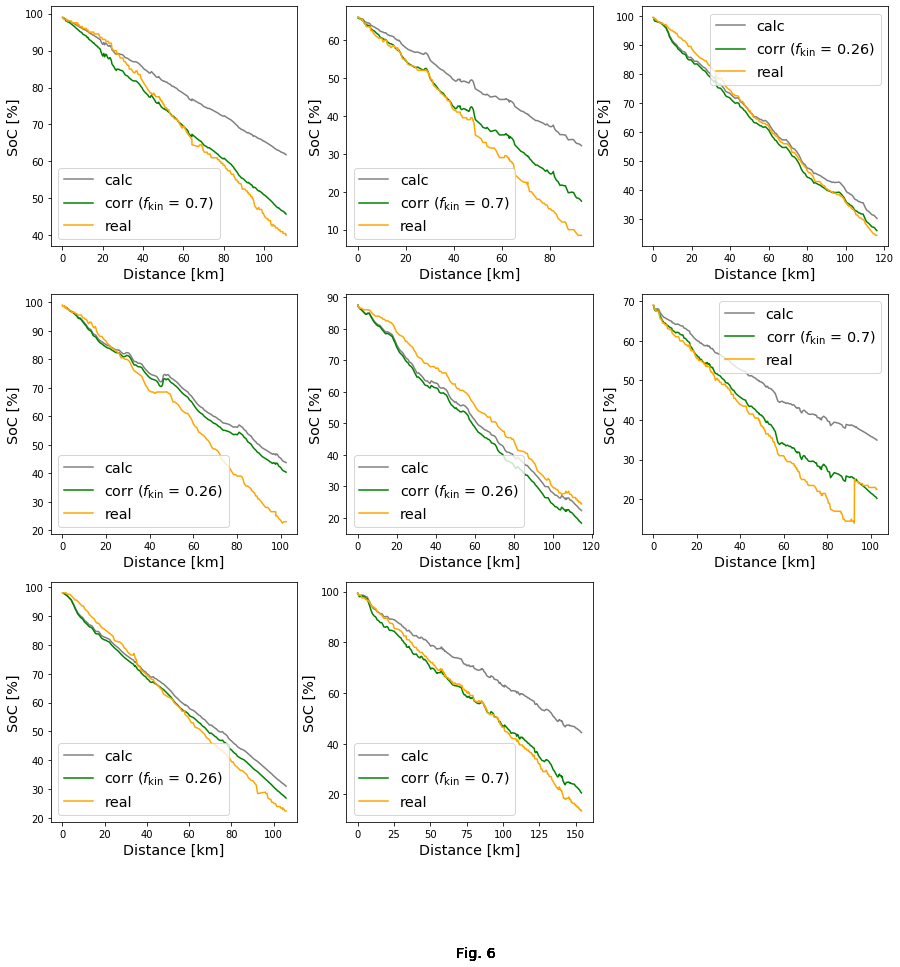

In [64]:
# Plot energy consumption profiles for some ioniq routes
i=0

for drive in hyundai_drives:
    
    def plotCurves(i, f_kin):
        fig = plt.figure(1, figsize=(15,15))
        ax1 = fig.add_subplot(3,3,i)
        ax1.plot(energyProfile.x, energyProfile.SoC*100, label='calc', c='black', alpha=0.5)
        ax1.plot(energyProfileCorr.x, energyProfileCorr.SoC*100, 
                 label=r'corr ($f_{{\rm kin}}$ = {})'.format(f_kin), c='green')
        ax1.plot(energyProfileCorr.x, drive.hvSocActualDisplay.iloc[:-1], label='real', c='orange')
        ax1.set_xlabel('Distance [km]', fontsize='x-large')
        ax1.set_ylabel('SoC [%]', fontsize='x-large')
        ax1.legend(fontsize='x-large')
        fig.text(0.5,0,'Fig. 6', fontsize='x-large')

        plt.tight_layout
    
    if drive.distance > 95:
        i+=1
        soc_ini=drive.hvSocActualDisplay.iloc[0]/100
        profile = getAltitude(drive)
        
        if drive.speed.median() > 60:
            f_kin = 0.26
        else:
            f_kin = 0.7
        
        energyProfileCorr = getProfileEnergy(auto, drive.speed.median(), profile, 
                                         soc_ini=soc_ini, eff=0.95, f_kin = f_kin)
        energyProfile = getProfileEnergy(auto, drive.speed.median(), profile, 
                                         soc_ini=soc_ini)
        
        plotCurves(i, f_kin)

### Comparison with other cars/drivers

In this section we aim to compare the values of $f_{\rm kin}$ and $eff$ that we determined for the ioniq Elektro, with those determined from real drive data from drivers on a Tesla Model S, Hyundai Kona and Kia eNiro. 

In [7]:
#########################################
#Collect data from other cars

#load kia data
kia = load_base2_ftp('ecu_bcddc2d0718c')
kia = kia[kia.model == 'KIAENIRO']

#select drive data, for kia the conditions are as below
mask = (kia.speed > 1) & (kia.hvBatteryCurrent != 1)

kia_drives = collect_drives(kia[mask])

#load tesla data
tesla = load_base2_ftp('ecu_bcddc2ceb734')
tesla = tesla[tesla.model == 'TESLA_S']

#select Drive data, for Tesla the conditions are as below
mask = (tesla.speed > 1) & (tesla.hvBatteryCurrent != 1)

#collect all data for each charging curve at store it as AutoCharge() objects
tesla_drives = collect_drives(tesla[mask])

#load Hyundai Ikona data
kona = load_base2_ftp('ecu_bcddc2d0718c')
kona = kona[kona.model == 'HYUNDAIKONA']

#select drive data, for kia the conditions are as below
mask = (kona.speed > 1) & (kona.hvBatteryCurrent != 1)

kona_drives = collect_drives(kona[mask])
#########################################

In [67]:
# minimize all available route data using Median and mean speed
def performMinimization(model, drives, statistic):
    auto = query_vehicle(model)
    
    data = [minimizeProfile(drive, auto, statistic=statistic) 
               for drive in drives if len(drive.speed) > 30]
    
    return pd.DataFrame(data)

eNiro_mean = performMinimization(model="e-Niro 64 kWh", drives=kia_drives, statistic='mean')
eNiro_median = performMinimization(model="e-Niro 64 kWh", drives=kia_drives, statistic='median')

kona_mean = performMinimization(model="KONA 64 kWh", drives=kona_drives, statistic='mean')
kona_median = performMinimization(model="KONA 64 kWh", drives=kona_drives, statistic='median')

tesla_mean = performMinimization(model="Model S 75D", drives=tesla_drives, statistic='mean')
tesla_median = performMinimization(model="Model S 75D", drives=tesla_drives, statistic='median')   

ioniq_mean = performMinimization(model="IONIQ Elektro", drives=hyundai_drives, statistic='mean')
ioniq_median = performMinimization(model="IONIQ Elektro", drives=hyundai_drives, statistic='median')

Table 3 below, shows the Pearsons $r$ correlation coefficient for all pairs of parameters for the cars/drivers mention before. As observed the $p$ values are for most pairs and cars, larger than 0.05. This means that there are no correlations that are statistically significant. Again, similar to the Ioniq (also included in the table), the only pair of parameters that seems to show a correlation is $f_{\rm kin}$-Speed. Where the correlation is negative. One of the main reasons of the bad statistics here presented is the fact that there are no enough data points (i.e., routes) for each car. Hence, such study needs to be repeated once there are more data to process.

In [71]:
def r_stats(df_mean,df_median):
    params = ['speed', 'distance total','eff', 'f_kin']    
    pearson_median=getPval(df_median, params)
    pearson_mean=getPval(df_mean, params)
    _=pd.concat([pearson_median,pearson_mean], keys=['Median','Mean'], axis=1)
    return _.iloc[1:,:]

autos = ['Tesla S', 'Kona', 'eNiro', 'Ioniq']

print('{:^100}'.format('Table 3'))

pd.concat([r_stats(tesla_mean, tesla_median),r_stats(kona_mean, kona_median), 
           r_stats(eNiro_mean, eNiro_median),r_stats(ioniq_mean,ioniq_median)],keys=autos, axis=1)

                                              Table 3                                               


Tesla S                     Kona                    \
                        Median        Mean       Median        Mean         
                             r     p     r     p      r     p     r     p   
Parameters                                                                  
eff - speed               0.23  0.39  0.33  0.21   0.39  0.16  0.36  0.20   
eff - distance total      0.37  0.16  0.44  0.09   0.38  0.18  0.48  0.08   
f_kin - speed            -0.42  0.11 -0.57  0.02  -0.27  0.36  0.05  0.88   
f_kin - distance total   -0.27  0.30 -0.43  0.10  -0.10  0.74  0.06  0.84   
f_kin - eff              -0.25  0.35 -0.09  0.75  -0.81  0.00 -0.44  0.11   

                        eNiro                    Ioniq                    
                       Median        Mean       Median        Mean        
                            r     p     r     p      r     p     r     p  
Parameters                                                                
eff - speed              0.06  0.57  0.01  0.91   0.04  0.69 -0.05  0.56  
eff - distance total    -0.00  0.99 -0.00  0.99  -0.08  0.39 -0.17  0.07  
f_kin - speed           -0.26  0.01 -0.18  0.07  -0.34  0.00 -0.25  0.01  
f_kin - distance total  -0.13  0.20 -0.08  0.44  -0.15  0.10 -0.16  0.08  
f_kin - eff             -0.36  0.00 -0.33  0.00  -0.22  0.02 -0.15  0.10

Lets continue anyway, by looking at the mean $f_{\rm kin}$ and $eff$ values determined for these cars/drivers under different driving conditions.

Table 4 below presents the mean $f_{\rm kin}$ and $eff$ values as obtained from the minimization procedures for all car routes.

In [74]:
def getParMeans(df_mean, df_median):
    
    hw_mean = df_mean[df_mean.highway==1]
    city_mean = df_mean[df_mean.highway==0]
    hw_median = df_median[df_median.highway==1]
    city_median = df_median[df_median.highway==0]

    par_means = pd.DataFrame()

    for m in [hw_mean, hw_median, city_mean, city_median]:
        par_means = pd.concat([par_means, pd.DataFrame({r'$f_{{\rm kin}}$':[ m.f_kin.mean().round(2)],
                                                        r'$eff$':[m.eff.mean().round(2)]
                                                       })])

    par_means['Conditions']=['Highway (mean)', 'Highway (median)','City (mean)', 'City (median)']

    return par_means.set_index('Conditions', drop=True)

print('{:^50}'.format('Table 4'))

autos = ['Tesla S', 'Kona', 'eNiro', 'Ioniq']
_= pd.concat([getParMeans(tesla_mean, tesla_median),getParMeans(kona_mean, kona_median), 
           getParMeans(eNiro_mean, eNiro_median),getParMeans(ioniq_mean,ioniq_median)],keys=autos, axis=1)
_

                     Table 4                      


Tesla S                  Kona                 eNiro  \
                 $f_{{\rm kin}}$ $eff$ $f_{{\rm kin}}$ $eff$ $f_{{\rm kin}}$   
Conditions                                                                     
Highway (mean)              0.76  0.96            0.57  0.99            0.41   
Highway (median)            0.70  0.92            0.47  0.99            0.30   
City (mean)                 1.31  0.86            0.73  0.90            0.72   
City (median)               1.18  0.83            0.74  0.88            0.69   

                                 Ioniq        
                 $eff$ $f_{{\rm kin}}$ $eff$  
Conditions                                    
Highway (mean)    0.93            0.41  0.94  
Highway (median)  0.93            0.26  0.95  
City (mean)       0.93            0.71  0.94  
City (median)     0.93            0.70  0.95

As shown in the table the efficiency for the eNiro and the Ioniq is the same when driving in the city or in the highway. In contrast, there are differences between these two driving conditions for the Kona and the Tesla. However, as given by the correlation statistics in table 3, these variance should not been taken seriously since it is not significant.

Regarding $f_{\rm kin}$, all cars/drivers show differences of values depending if one drives in the city or on a highway. Hence, for larger speeds, i.e, highways, $f_{\rm kin}$ is smaller. As earlier discussed, this is related to the fact that driving conditions in highways are smoother than in-city conditions where complex traffic conditions require more acceleration/breaking  events that enhance the consumption of kinetic energy.

To finalize let us have a graphical overview of $f_{\rm kin}$. Figure 7 shows the $f_{\rm kin}$ values for the different cars determined using the median speed. From the figure we can observe that the Tesla driver seems to be the one who consumes more kinetic energy of the four drivers here considered, whereas the Ioniq driver seems to be more economic in this sense.

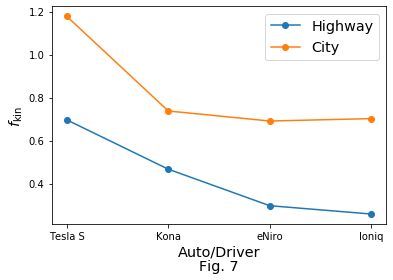

In [114]:
f_kin_means_hw = [car.f_kin.mean() for car in [tesla_median[tesla_median.highway==1], 
                                            kona_median[kona_median.highway==1],
                                            eNiro_median[eNiro_median.highway==1],
                                            ioniq_median[ioniq_median.highway==1]
              ]]

f_kin_means_city = [car.f_kin.mean() for car in [tesla_median[tesla_median.highway==0], 
                                            kona_median[kona_median.highway==0],
                                            eNiro_median[eNiro_median.highway==0],
                                            ioniq_median[ioniq_median.highway==0]
              ]]

plt.plot(autos, f_kin_means_hw, 'o-', label='Highway' )
plt.plot(autos, f_kin_means_city, 'o-', label='City' )
plt.xlabel('Auto/Driver', fontsize='x-large')
plt.ylabel(r'$f_{\rm kin}$', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.text(1.3,0,'Fig. 7', fontsize='x-large');


## Summary

To summarize, we have analyze the energy consumption profiles of electric vehicles when driving along a given route. Using a optimization approach where we minimize the difference in energy consumption profiles between  calculated and real data, we were able to obtain the amount of kinetic energy consumed during the route and the motor efficiency of the car. After a statistical analysis we identified a negative correlation of the kinetic energy with the driving speed which allowed us to differentiate two driving conditions namely highway and city. Thus, the kinetic energy consumption is larger under city driving conditions than on highway conditions. 

Furthermore, we were able to demonstrate that by using the mean values of $f_{\rm kin}$ for highway and city conditions, the calculation of the overall energy consumption profile was closer to the real profiles, which would be an improvement on the current routing algorithm.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


ioniq_median = median_df[['speed', 'distance total', 'eff', 'E_dynamic', 'highway']]

# test size = 20% of data, one split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for train_idx, test_idx in split.split(ioniq_median, ioniq_median['highway']):
    strat_train = ioniq_median.loc[train_idx]
    strat_test = ioniq_median.loc[test_idx]    

ioniq_median_train_features = strat_train[['speed', 'distance total', 'highway']]
ioniq_median_train_targets = strat_train[['eff','E_dynamic']]

ioniq_median_test_features = strat_test[['speed', 'distance total', 'highway']]
ioniq_median_test_targets = strat_test[['eff','E_dynamic']]

linreg = LinearRegression()
kneighbours = KNeighborsRegressor()
rforest = RandomForestRegressor()

models = [linreg, kneighbours, rforest]
labels = ['Linear Reg', 'K Neighbors', 'Random Forest']


skf = StratifiedKFold(n_splits=5)

def compare_model_scores(models, X, y, labels):
    """
    This function compares predictive scores from different ML algorithms
    """
    print('='*50)
    print('Model\t\tscore')
    print('-'*50)
      
    for i, model in enumerate(models):

        # perform Kfold cross-validation returning prediction scores of each test fold.
#        labels_train_pred = cross_val_score(model, X, y, cv=5)#, scoring='r2')#, scoring=mse_scorer)
        labels_train_pred = cross_val_score(model, X, y, cv=skf.split(X,X.highway))
        print('{}\t\t{:0.3f}'.format(labels[i],labels_train_pred.mean()))
        #print('-'*50)
        
    print('='*50)

compare_model_scores(models, ioniq_median_train_features, ioniq_median_train_targets, labels)    

    
    
linreg.fit(ioniq_median_train_features, ioniq_median_train_targets)

ioniq_median_pred = linreg.predict(ioniq_median_test_features)

# The coefficients
print('Coefficients: \n', linreg.coef_)
# The mean squared error
print('Mean squared error: {:.2f}'.format(mean_squared_error(ioniq_median_test_targets, ioniq_median_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: {:.2f}'.format(r2_score(ioniq_median_test_targets, ioniq_median_pred)))#, multioutput='variance_weighted')))